The following tutorial reproduces the results of Tutorial 1 on spinw.org. It is the spin wave spectrum of Heisenberg ferromagnetic nearest-neighbor spin chain.

Getting required packages

In [1]:
using Sunny, GLMakie, CairoMakie  

Define spin chain with magnetic atoms. Set up the lattice, the position of magnetic atoms, the symmetry inequivalent postions and the spin. Print Symmetry table can be used to see the allowed exchange matrices. Here, Cu+ atoms have spin =1 and are located at the origin og the unit cell.

In [2]:
a=8.0
b=8.0
c=3.0

latvecs = lattice_vectors(a, b, c, 90, 90, 90) #defining the lattice
positions=[[0, 0, 0]]
types=["Cu1"]

cryst = Crystal(latvecs, positions; types)

GLMakie.activate!()
view_crystal(cryst)

print_symmetry_table(cryst,8)

sys=System(cryst, (1,1,1),[SpinInfo(1,S=1,g=2)], :dipole, seed=0)

Atom 1
Type 'Cu1', position [0, 0, 0], multiplicity 1
Allowed g-tensor: [A 0 0
                   0 A 0
                   0 0 B]
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,0] +
    c₂*𝒪[4,0] + c₃*𝒪[4,4] +
    c₄*𝒪[6,0] + c₅*𝒪[6,4]

Bond(1, 1, [0, 0, 1])
Distance 3, coordination 2
Connects 'Cu1' at [0, 0, 0] to 'Cu1' at [0, 0, 1]
Allowed exchange matrix: [A 0 0
                          0 A 0
                          0 0 B]

Bond(1, 1, [0, 0, 2])
Distance 6, coordination 2
Connects 'Cu1' at [0, 0, 0] to 'Cu1' at [0, 0, 2]
Allowed exchange matrix: [A 0 0
                          0 A 0
                          0 0 B]

Bond(1, 1, [1, 0, 0])
Distance 8, coordination 4
Connects 'Cu1' at [0, 0, 0] to 'Cu1' at [1, 0, 0]
Allowed exchange matrix: [A 0 0
                          0 B 0
                          0 0 C]



System [Dipole mode]
Lattice (1×1×1)×1
Energy per site 0


Define the spin Hamiltonian. It is a nearest neighbour only ferromagnetic heisenberg interaction so J is negative. Set up the exchange, randomize the spins and then minimize the energy of the system to achieve the ground state.

In [3]:
J1=-1
set_exchange!(sys,J1,Bond(1, 1, [0, 0, 1]))
randomize_spins!(sys)
minimize_energy!(sys)
plot_spins(sys)
energy(sys)

-1.0000000000000002

Perform Linear Spin Wave Theory calculations on the system. Create a spinw object, set up a path and calculate the dispersion bands and their intensity.

In [4]:
swt=SpinWaveTheory(sys)
η = 0.4 # (meV)
kernel = lorentzian(η)
q_points = [[0,0,0], [0,0,1]]
density = 50
path, xticks = reciprocal_space_path(cryst, q_points, density);
disp = dispersion(swt, path);
formula = intensity_formula(swt, :perp; kernel=delta_function_kernel)
disp, intensity = intensities_bands(swt, path, formula);

Plotting the results. Plot the dispersion, the broadening, powder averaged results and the spin spin correlation.

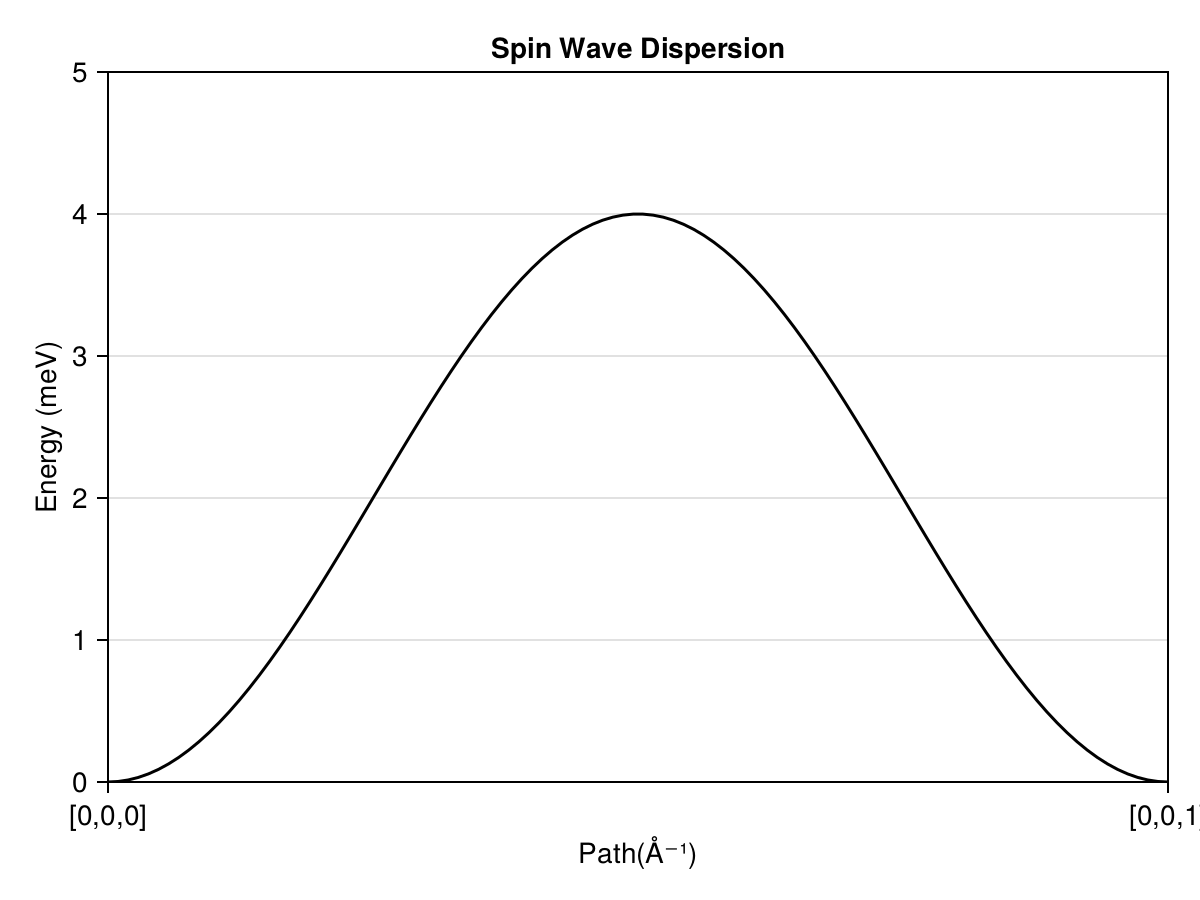

In [5]:
CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Path(Å⁻¹)", ylabel="Energy (meV)", title="Spin Wave Dispersion",xticks)
ylims!(ax, 0.0, 5)
xlims!(ax, 1, size(disp, 1))
colorrange = extrema(intensity)
for i in axes(disp)[2]
    lines!(ax, 1:length(disp[:,i]), disp[:,i];color="black",colorrange)
end
fig

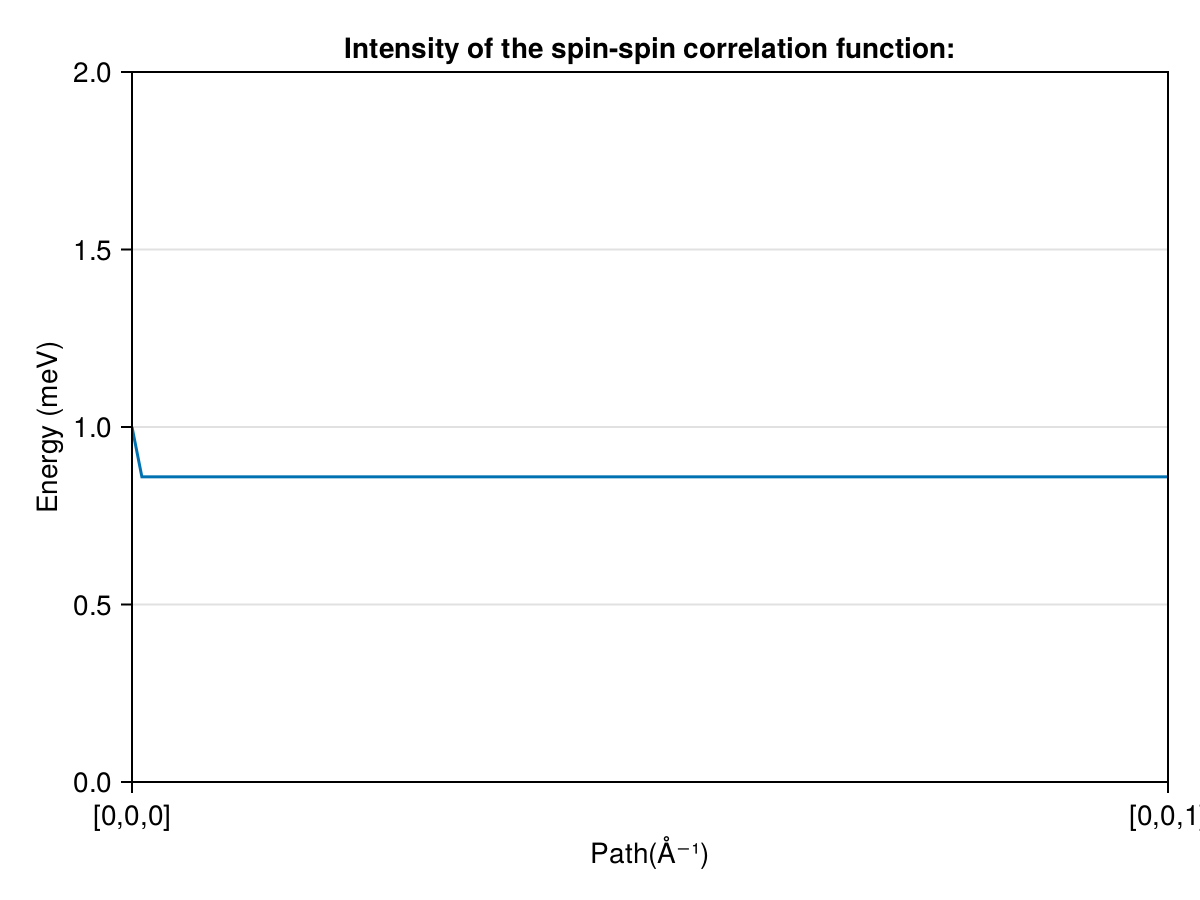

In [6]:
γ = 0.15 # width in meV
broadened_formula = intensity_formula(swt, :perp; kernel=lorentzian(γ))
energies = collect(0:0.01:10)  # 0 < ω < 10 (meV).
is1 = intensities_broadened(swt, path, energies, broadened_formula);

fig = Figure()
ax = Axis(fig[1,1]; xlabel="Path(Å⁻¹)", ylabel="Energy (meV)",title="Intensity of the spin-spin correlation function:", xticks)
ylims!(ax, 0.0, 2)
xlims!(ax, 1, size(disp, 1))
colorrange = extrema(intensity)
for i in axes(disp)[2]
    lines!(ax, 1:length(intensity[:,i]), intensity[:,i]; colorrange)
end
fig


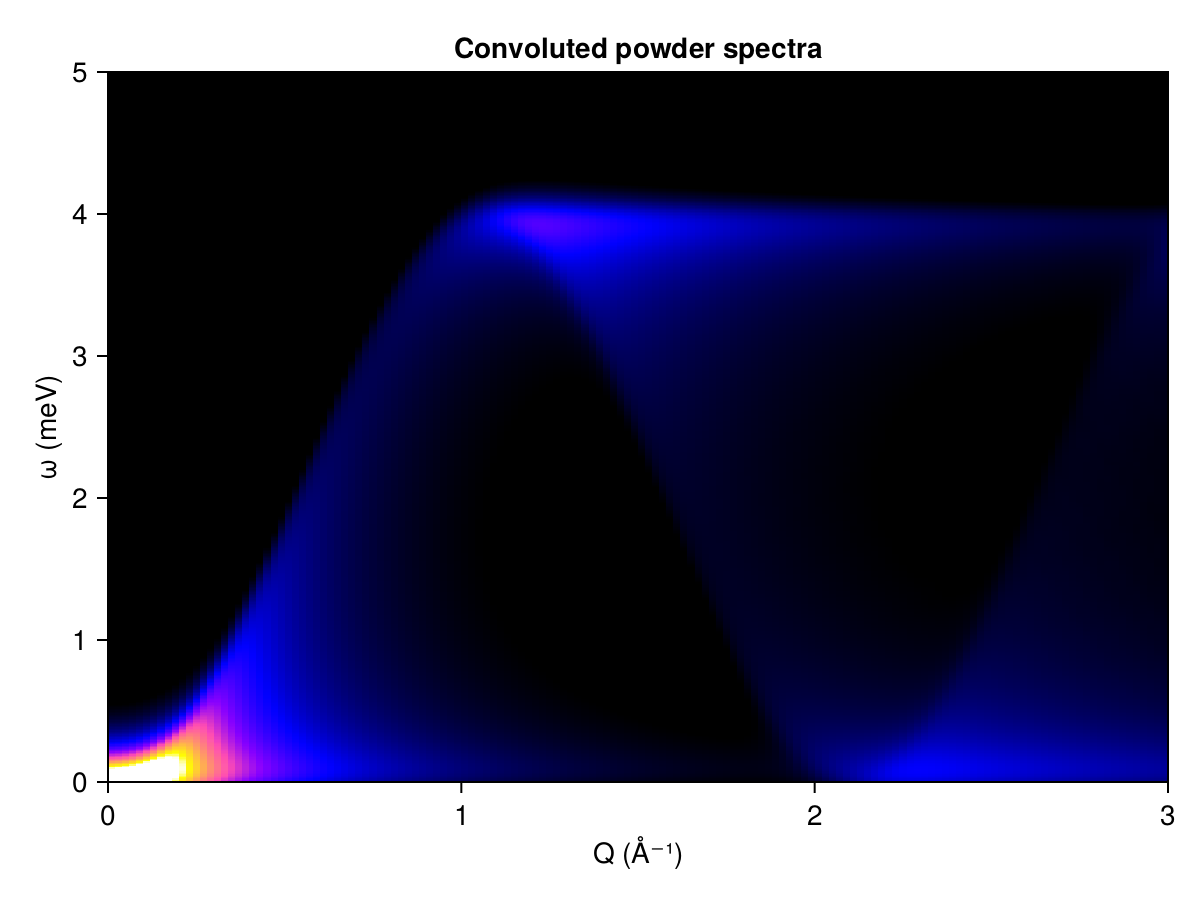

In [7]:
radii = 0.01:0.02:3 # (1/Å)##powder averaging
output = zeros(Float64, length(radii), length(energies))
for (i, radius) in enumerate(radii)
    n = 300
    qs = reciprocal_space_shell(cryst, radius, n)
    is1 = intensities_broadened(swt, qs, energies, broadened_formula)
    output[i, :] = sum(is1, dims=1) / size(is1, 1)
end

fig = Figure()
ax = Axis(fig[1,1]; xlabel="Q (Å⁻¹)", ylabel="ω (meV)", title="Convoluted powder spectra")
ylims!(ax, 0.0, 5.0)
heatmap!(ax, radii, energies, output, colormap=:gnuplot2,colorrange=(0.1,1))
fig
